# Task 2

### Develop and train a neural network model with PyTorch on the BBBP dataset used in HW5 by using Morgan fingerprints.  
Please explore a few model architectures  and compare your results with the default random forest model that have been developed in HW5.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import torch
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn

**Import data**

In [5]:
bbbp = pd.read_csv("BBBP.csv")
bbbp.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


**Calculate morgan fingerprints**

In [6]:
# suppress warnings from invalid molecules
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [7]:
# function: generate canon SMILES
def gen_canon_smiles(smiles_list):
    
    invalid_ids = []
    canon_smiles = []

    for i in range(len(smiles_list)):   
        mol = Chem.MolFromSmiles(smiles_list[i])
        
        # do not append NoneType if invalid
        if mol is None: 
            invalid_ids.append(i)
            continue

        canon_smiles.append(Chem.MolToSmiles(mol))

    return canon_smiles, invalid_ids

In [8]:
# function: calculate morgan fingerprints from SMILES
def calc_morgan_fpts(smiles_list):
    morgan_fingerprints = []
    
    for i in smiles_list:
        mol = Chem.MolFromSmiles(i)
        
        # do not try to calculate if invalid
        if mol is None: continue
            
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        morgan_fingerprints.append(mfpts) 
        
    return np.array(morgan_fingerprints)

In [9]:
# generate canon smiles
canon_smiles, invalid_ids = gen_canon_smiles(bbbp.smiles)

# drop rows with invalid SMILES
bbbp = bbbp.drop(invalid_ids)

# replace SMILES with canon SMILES
bbbp.smiles = canon_smiles

# drop duplicates to prevent train/valid/test contamination
bbbp.drop_duplicates(subset=['smiles'], inplace=True)

In [10]:
X = torch.from_numpy(calc_morgan_fpts(bbbp.smiles)).float()
y = torch.from_numpy(bbbp.p_np.values)

In [11]:
bbbp_ds = TensorDataset(X, y)

**Split data**

In [12]:
init_train_ds, train_ds, valid_ds, test_ds = random_split(bbbp_ds, [0.08, 0.72, 0.1, 0.1])

**Create a ```DataLoader``` for each ```TensorDataset```**

In [13]:
batch_size = 2

init_train_dl = DataLoader(init_train_ds, batch_size, shuffle=True)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(test_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

**Build and test NN model(s)**

In [14]:
# use GPU for training if available
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


* **Model_0**

In [15]:
class Model_0(nn.Module):
    def __init__(self):
        super(Model_0, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.BatchNorm1d(2048), 
            nn.Linear(2048, 256), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.Linear(256, 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.stack(x)
        return logits

In [16]:
model_0 = Model_0().to(device)
print(model_0)

Model_0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (stack): Sequential(
    (0): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=2, bias=True)
  )
)


* **Optimize model_0 parameters**

In [17]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model_0.parameters(), lr=learning_rate)

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [19]:
def eva(dataloader, model):
    size = len(dataloader)
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()*y.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= size
    correct /= size*2
    return loss, correct

In [20]:
epochs = 40
init_train_loss_hist, init_train_acc_hist = [], []
valid_loss_hist, valid_acc_hist = [], []

train_loss, train_acc = eva(init_train_dl, model_0)
valid_loss, valid_acc = eva(valid_dl, model_0)

init_train_loss_hist.append(train_loss)
init_train_acc_hist.append(train_acc)
valid_loss_hist.append(valid_loss)
valid_acc_hist.append(valid_acc)

print("Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Valid Loss: {:.4f}, Valid Acc: {:.2f}%".format(
    0, epochs, train_loss, train_acc*100, valid_loss, valid_acc*100))

for epoch in range(epochs):
    train(init_train_dl, model_0, loss_fn, optimizer)
    
    train_loss, train_acc = eva(init_train_dl, model_0)
    vaid_loss, valid_acc = eva(valid_dl, model_0)
    
    init_train_loss_hist.append(train_loss)
    init_train_acc_hist.append(train_acc)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    
    print("Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Valid Loss: {:.4f}, Valid Acc: {:.2f}%".format(
        epoch+1, epochs, train_loss, train_acc*100, valid_loss, valid_acc*100))

Epoch [0/40], Train Loss: 1.4534, Train Acc: 26.88%, Valid Loss: 1.4675, Valid Acc: 22.22%
Epoch [1/40], Train Loss: 1.4226, Train Acc: 26.88%, Valid Loss: 1.4675, Valid Acc: 22.22%
Epoch [2/40], Train Loss: 1.3952, Train Acc: 26.88%, Valid Loss: 1.4675, Valid Acc: 22.22%
Epoch [3/40], Train Loss: 1.3695, Train Acc: 71.88%, Valid Loss: 1.4675, Valid Acc: 69.19%
Epoch [4/40], Train Loss: 1.3462, Train Acc: 72.50%, Valid Loss: 1.4675, Valid Acc: 77.27%
Epoch [5/40], Train Loss: 1.3249, Train Acc: 72.50%, Valid Loss: 1.4675, Valid Acc: 77.27%
Epoch [6/40], Train Loss: 1.3062, Train Acc: 72.50%, Valid Loss: 1.4675, Valid Acc: 77.27%
Epoch [7/40], Train Loss: 1.2888, Train Acc: 72.50%, Valid Loss: 1.4675, Valid Acc: 77.27%
Epoch [8/40], Train Loss: 1.2729, Train Acc: 72.50%, Valid Loss: 1.4675, Valid Acc: 77.27%
Epoch [9/40], Train Loss: 1.2588, Train Acc: 72.50%, Valid Loss: 1.4675, Valid Acc: 77.27%
Epoch [10/40], Train Loss: 1.2456, Train Acc: 72.50%, Valid Loss: 1.4675, Valid Acc: 77.27

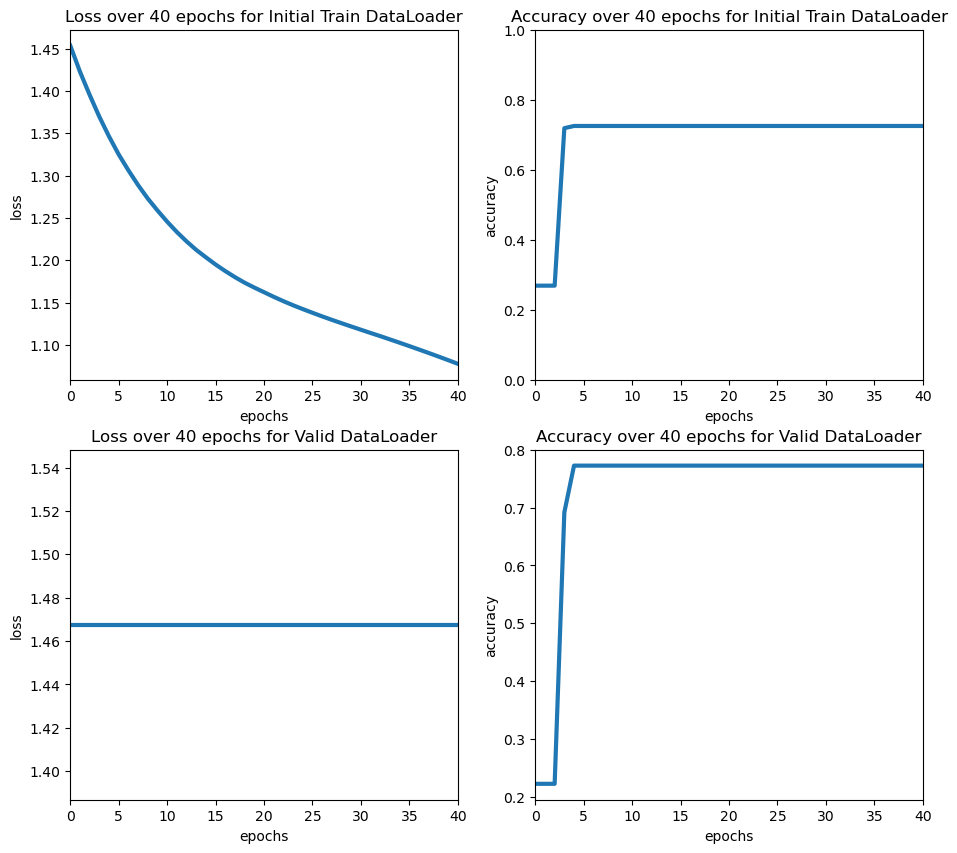

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(11, 10))

axs[0, 0].plot(init_train_loss_hist, linewidth=3)
axs[0, 0].set_title("Loss over " + str(epochs) + " epochs for Initial Train DataLoader")
axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("loss")
axs[0, 0].set_xlim([0, epochs])

axs[1, 0].plot(valid_loss_hist, linewidth=3)
axs[1, 0].set_title("Loss over " + str(epochs) + " epochs for Valid DataLoader")
axs[1, 0].set_xlabel("epochs")
axs[1, 0].set_ylabel("loss")
axs[1, 0].set_xlim([0, epochs])

axs[0, 1].plot(init_train_acc_hist, linewidth=3)
axs[0, 1].set_title("Accuracy over " + str(epochs) + " epochs for Initial Train DataLoader")
axs[0, 1].set_ylabel("accuracy")
axs[0, 1].set_xlabel("epochs")
axs[0, 1].set_xlim([0, epochs])
axs[0, 1].set_ylim([0, 1])

axs[1, 1].plot(valid_acc_hist, linewidth=3)
axs[1, 1].set_title("Accuracy over " + str(epochs) + " epochs for Valid DataLoader")
axs[1, 1].set_ylabel("accuracy")
axs[1, 1].set_xlabel("epochs")
axs[1, 1].set_xlim([0, epochs])

plt.show()

In [22]:
def train_with_validation(train_set, valid_set, model, loss_fn, optimizer, epochs=0):
    train_loss_hist = []
    train_acc_hist = []
    valid_loss_hist = []
    valid_acc_hist = []
    
    train_loss, train_acc = eva(train_set, model)
    valid_loss, valid_acc = eva(valid_set, model)
    
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    
    for epoch in range(epochs):
        train(train_set, model, loss_fn, optimizer)
        
        train_loss, train_acc = eva(train_set, model)
        valid_loss, valid_acc = eva(valid_set, model)

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        valid_loss_hist.append(valid_loss)
        valid_acc_hist.append(valid_acc)
        
    return train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist

In [23]:
epochs = 100

train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist = train_with_validation(
    train_dl, valid_dl, model_0, loss_fn, optimizer, epochs)

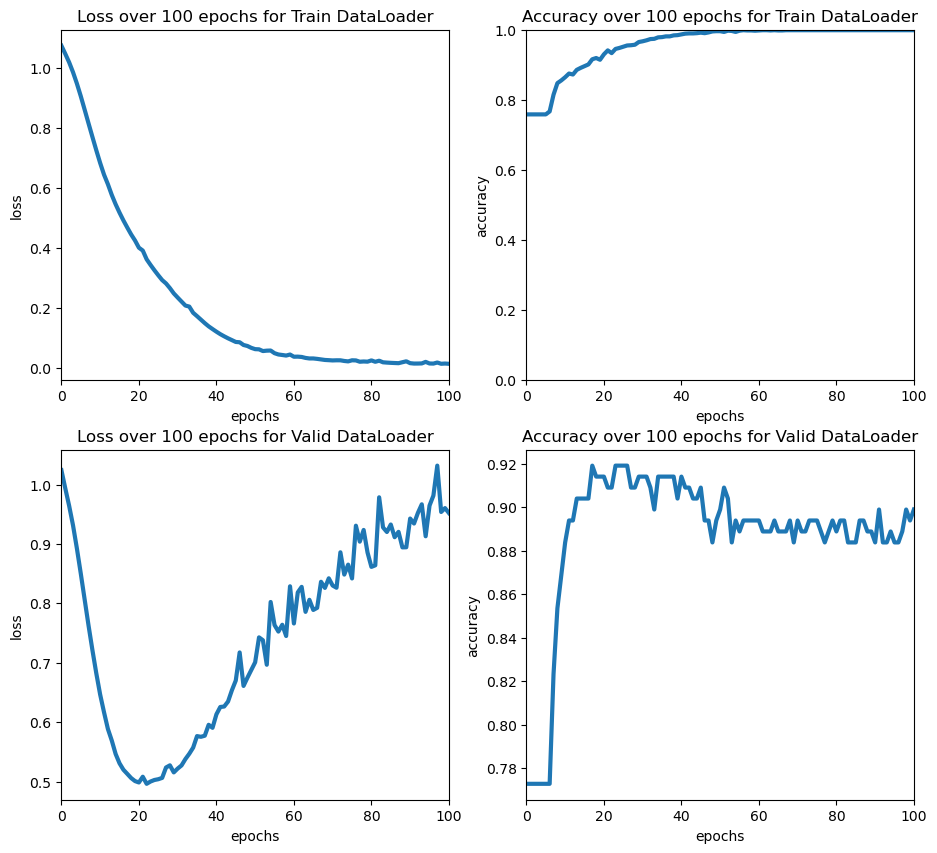

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(11, 10))

axs[0, 0].plot(train_loss_hist, linewidth=3)
axs[0, 0].set_title("Loss over " + str(epochs) + " epochs for Train DataLoader")
axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("loss")
axs[0, 0].set_xlim([0, epochs])

axs[1, 0].plot(valid_loss_hist, linewidth=3)
axs[1, 0].set_title("Loss over " + str(epochs) + " epochs for Valid DataLoader")
axs[1, 0].set_xlabel("epochs")
axs[1, 0].set_ylabel("loss")
axs[1, 0].set_xlim([0, epochs])

axs[0, 1].plot(train_acc_hist, linewidth=3)
axs[0, 1].set_title("Accuracy over " + str(epochs) + " epochs for Train DataLoader")
axs[0, 1].set_ylabel("accuracy")
axs[0, 1].set_xlabel("epochs")
axs[0, 1].set_xlim([0, epochs])
axs[0, 1].set_ylim([0, 1])

axs[1, 1].plot(valid_acc_hist, linewidth=3)
axs[1, 1].set_title("Accuracy over " + str(epochs) + " epochs for Valid DataLoader")
axs[1, 1].set_ylabel("accuracy")
axs[1, 1].set_xlabel("epochs")
axs[1, 1].set_xlim([0, epochs])

plt.show()

* **Model_1**

In [25]:
# use GPU for training if available
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [26]:
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.BatchNorm1d(2048), 
            nn.Linear(2048, 256), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.stack(x)
        return logits

In [27]:
model_1 = Model_1().to(device)
print(model_1)

Model_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (stack): Sequential(
    (0): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)


Optimize model parameters

In [28]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model_0.parameters(), lr=learning_rate)

In [29]:
epochs = 40

train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist = train_with_validation(
    init_train_dl, valid_dl, model_1, loss_fn, optimizer, epochs)

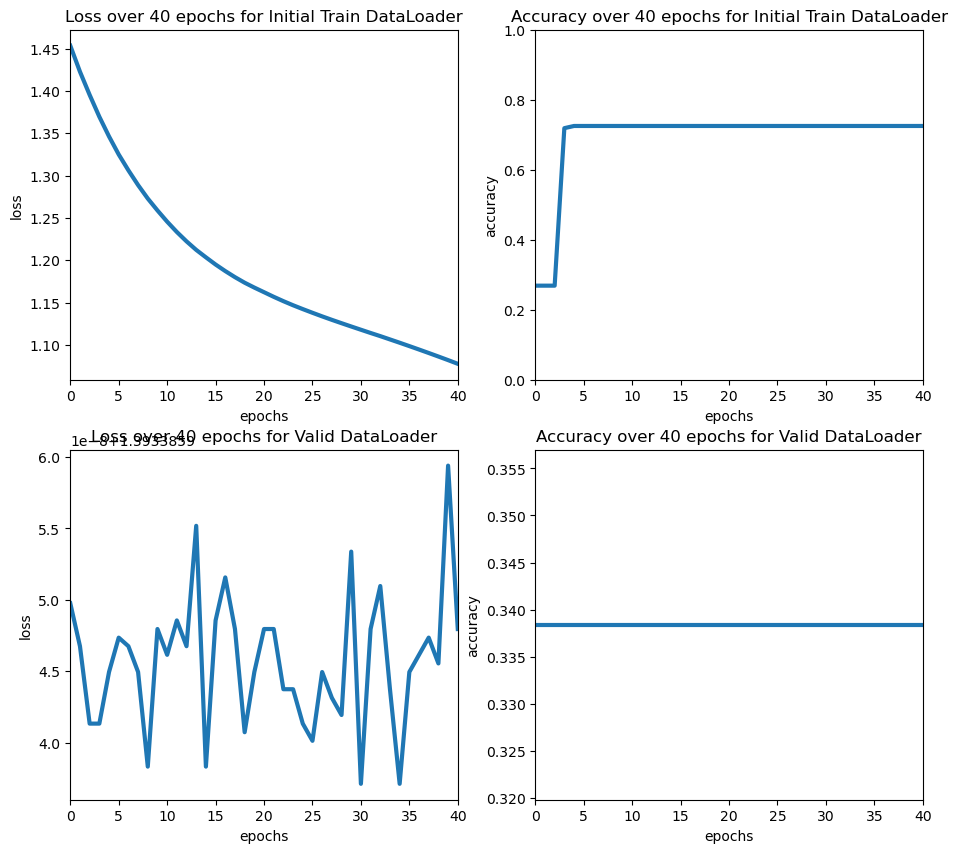

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(11, 10))

axs[0, 0].plot(init_train_loss_hist, linewidth=3)
axs[0, 0].set_title("Loss over " + str(epochs) + " epochs for Initial Train DataLoader")
axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("loss")
axs[0, 0].set_xlim([0, epochs])

axs[1, 0].plot(valid_loss_hist, linewidth=3)
axs[1, 0].set_title("Loss over " + str(epochs) + " epochs for Valid DataLoader")
axs[1, 0].set_xlabel("epochs")
axs[1, 0].set_ylabel("loss")
axs[1, 0].set_xlim([0, epochs])

axs[0, 1].plot(init_train_acc_hist, linewidth=3)
axs[0, 1].set_title("Accuracy over " + str(epochs) + " epochs for Initial Train DataLoader")
axs[0, 1].set_ylabel("accuracy")
axs[0, 1].set_xlabel("epochs")
axs[0, 1].set_xlim([0, epochs])
axs[0, 1].set_ylim([0, 1])

axs[1, 1].plot(valid_acc_hist, linewidth=3)
axs[1, 1].set_title("Accuracy over " + str(epochs) + " epochs for Valid DataLoader")
axs[1, 1].set_ylabel("accuracy")
axs[1, 1].set_xlabel("epochs")
axs[1, 1].set_xlim([0, epochs])

plt.show()

In [31]:
epochs = 100

train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist = train_with_validation(
    train_dl, valid_dl, model_1, loss_fn, optimizer, epochs)

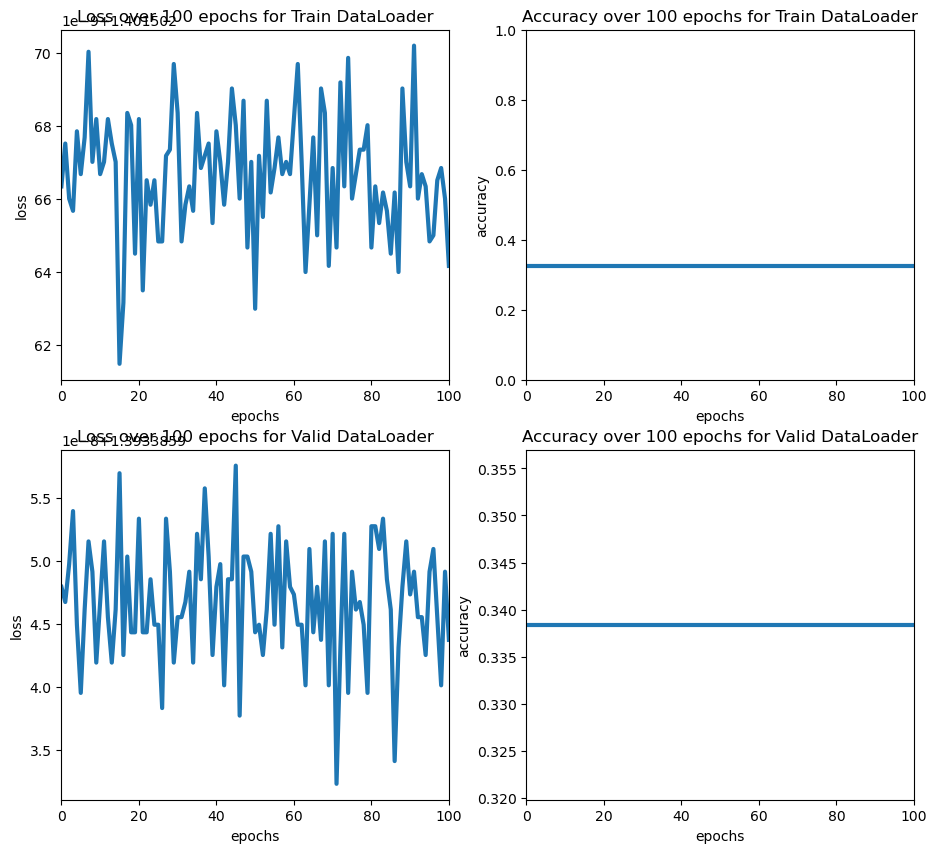

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(11, 10))

axs[0, 0].plot(train_loss_hist, linewidth=3)
axs[0, 0].set_title("Loss over " + str(epochs) + " epochs for Train DataLoader")
axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("loss")
axs[0, 0].set_xlim([0, epochs])

axs[1, 0].plot(valid_loss_hist, linewidth=3)
axs[1, 0].set_title("Loss over " + str(epochs) + " epochs for Valid DataLoader")
axs[1, 0].set_xlabel("epochs")
axs[1, 0].set_ylabel("loss")
axs[1, 0].set_xlim([0, epochs])

axs[0, 1].plot(train_acc_hist, linewidth=3)
axs[0, 1].set_title("Accuracy over " + str(epochs) + " epochs for Train DataLoader")
axs[0, 1].set_ylabel("accuracy")
axs[0, 1].set_xlabel("epochs")
axs[0, 1].set_xlim([0, epochs])
axs[0, 1].set_ylim([0, 1])

axs[1, 1].plot(valid_acc_hist, linewidth=3)
axs[1, 1].set_title("Accuracy over " + str(epochs) + " epochs for Valid DataLoader")
axs[1, 1].set_ylabel("accuracy")
axs[1, 1].set_xlabel("epochs")
axs[1, 1].set_xlim([0, epochs])

plt.show()

In my trial, ```model_0``` seems to perform significantly better than ```model_1```, so I will use ```model_0``` to evaluate on the test set.

**Evaluate on the test set**

In [33]:
test_loss, test_acc = eva(train_dl, model_0)

In [34]:
print("loss:", test_loss, "\naccuracy:", test_acc)

loss: 0.0138240942367941 
accuracy: 0.9985935302390999


The model I developed in homework 5 had an ROC-AUC performance score of approximately 0.85. However, since ROC-AUC and performance don't measure the same thing, they cannot be compared directly. Instead, I went back to calculate the accuracy score of my random forest model. The accuracy of my random forest model on the test set was shown to be 0.87. This is significantly lower than the accuracy of my NN model which I developed in this project.